In [1]:
import pandas as pd
from pprint import pprint
import pystan
from scipy.special import expit
from matplotlib import pyplot as plt
from numpy.random import normal, randint, binomial, choice
from numpy import percentile, concatenate, array, linspace, append
%matplotlib inline

# Teddy Groves
# How to test IRT models using simulated data

My company, [Football Radar](https://www.footballradar.com/), is interested in lots of tasks that can be performed better or worse, depending on how hard it is and how able the agent doing it is. 

Specifically, we look at data encoding judgements by football scouts as to how well players perform different kinds of action, such as controlling a fast-moving ball under pressure from an opponent. Typically not all players attempt the same kinds of actions the same number of times. In these cases IRT models can be used to draw conclusions about the players' abilities and the tasks' difficulties. 

This notebook explains how to code some IRT models using Stan and test whether they can recover input parameters when given simulated data.

## What are IRT models?
The acronym IRT stands for 'item response theory'. This kind of model and its generalisations are very well explained in Gelman and Hill (2006). 

The main point for our purposes is that IRT models assume that some response variables - we'll call them 'grades' - depend probabilistically on unobserved features of the 'subjects' - in our application football players - and tasks, or 'items', that is that can be thought of as abilities and difficulties. In other words:

$$pr(grade_{ij} = s) = f(ability_{j}, difficulty_{i})$$

In the case of binary data this schema is typically fleshed out as follows:  

$$pr(grade_{ij} = 1) = logistic(ability_{j} - difficulty_{i})$$

The subtraction relationship represents an assumption that the likelihood of correctness depends on the difference between the item's difficulty and the subject's ability, which is reasonable in a lot of applications. The logistic function fixes the direction of this dependence, and conveniently ensures that any possible ability/difficulty difference is mapped to a number between zero and one:

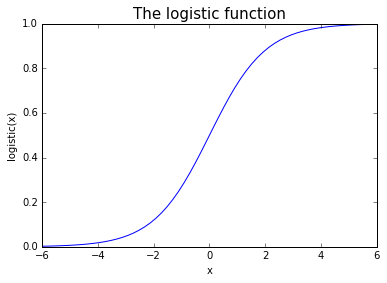

In [2]:
x_axis = linspace(-10, 10, 100)
plt.plot(x_axis, expit(x_axis))
plt.xlabel('x')
plt.xlim([-6, 6])
plt.ylabel('logistic(x)')
plt.title('The logistic function', fontsize=15)


## Binary IRT model
Here is how to code a binary IRT model in Stan:
```
data {
  // numbers of things
  int<lower=1> R;  // responses
  int<lower=1> I;  // items
  int<lower=1> S;  // subjects
  // data
  int<lower=1,upper=I> item[R];
  int<lower=1,upper=S> subject[R];
  int<lower=0,upper=1> grade[R];
}
parameters {
  // parameters
  vector[S] ability;
  vector[I] difficulty;
  // hyperparameters
  real mu_difficulty;
  real<lower=0> sigma_difficulty;
  real<lower=0> sigma_ability;
}
model {
  // priors
  ability ~ normal(0, sigma_ability);
  difficulty ~ normal(0, sigma_difficulty);
  mu_difficulty ~ cauchy(0, 5);
  // data model
  grade ~ bernoulli_logit(ability[subject] - difficulty[item] - mu_difficulty);
}
```
The data model is what makes this an IRT model, so naturally it has the form described above - the grade vector has a logistic distribution, where each repsonse's success probability depends on the difference between the ability of the subject attempting it and the difficulty of the item being attempted. 

The difficulty parameters are given a non-centered parameterisation, so that the mean difficulty and the deviations of individual items' difficulties from this mean are defined separately as `mu_difficulty` and `difficulty` respectively. In applications where a lot of data is available, a centred parameterisation, i.e. `difficulty ~ normal(mu_difficulty, sigma_difficulty)` and `grade ~ bernoulli_logit(ability[subject] - difficulty[item])`, might be more appropriate. See the section of the Stan manual on 'Reparameterisation' for more on this topic.

A bit of care has to be taken with the prior distributions for the `difficulty` and `ability` parameters, as the data model is only sensitive to their differences, not their absolute values. This notebook deals with this issue using 'soft centering', that is, fixing the location of one or other parameter's prior distribution, so that, all else equal, the model will choose ability parameter values that sum to zero.

Alternatively, a sum-to-zero constraint could have been imposed directly using a `transformed parameters` block. See the section of the Stan manual on 'Parameterizing Centered Vectors' for details about this approach, known as 'hard centering'.

The scale of the `ability` and `difficulty` parameters' priors are set hierarchically, using hyperparameters `sigma_ability` and `sigma_difficulty`. In this way we avoid having to specify the scales, which is generally a good idea in the absence of any information.

Once we have coded our model, we can put it in a `.stan` file and compile it using the following code:

In [3]:
binary_irt_model = pystan.StanModel(file="binary_irt.stan")

### Simulated data
A good way to check if a model is doing what you think it should is to test it on simulated data. 

Here we verify that the binary IRT model we just compiled can recover some randomly generated parameters.

First we need to generate some random data. Here's how to do it using functions from numpy and scipy: 

In [4]:
def generate_binary_irt_data(sim_input):
    # simulate abilities, difficulties, and subject/item combinations
    sim_ability = normal(loc=0,
                         scale=sim_input['sigma_ability'],
                         size=sim_input['S'])
    sim_difficulty = normal(loc=sim_input['mu_difficulty'],
                            scale=sim_input['sigma_difficulty'],
                            size=sim_input['I'])
    sim_subject = randint(low=0,
                          high=sim_input['S'],
                          size=sim_input['R'])
    sim_item = randint(low=0,
                       high=sim_input['I'],
                       size=sim_input['R'])
    # work out success probabilities
    sim_success_probabilities = expit(sim_ability[sim_subject] -
                                      sim_difficulty[sim_item])
    # simulate grades
    sim_grade = binomial(n=1,
                         p=sim_success_probabilities,
                         size=sim_input['R'])
    # Dictionary of data to give to STAN
    sim_data = {
        'grade': sim_grade,
        'subject': sim_subject + 1,
        'item': sim_item + 1,
    }
    sim_data.update({i: binary_sim_input[i] for i in ['R', 'I', 'S']})
    recoverables = {
        'ability': sim_ability,
        'difficulty': sim_difficulty,
    }
    recoverables.update({i: binary_sim_input[i] for i in ['sigma_ability',
                                                          'mu_difficulty',
                                                          'sigma_difficulty']})
    return sim_data, recoverables

# define some input data
binary_sim_input = {'R': 10000,
                    'I': 15,
                    'S': 15,
                    'sigma_ability': 1,
                    'sigma_difficulty': 2,
                    'mu_difficulty': -1}
binary_sim_data, binary_sim_recoverables = generate_binary_irt_data(binary_sim_input)
# print results
print('Here is our randomly generated data:')
pprint(binary_sim_data)  # pprint makes the dictionary print nicely

Here is our randomly generated data:
{'I': 15,
 'R': 10000,
 'S': 15,
 'grade': array([1, 1, 1, ..., 1, 1, 1]),
 'item': array([10,  2,  3, ...,  5, 13,  6]),
 'subject': array([10,  6, 12, ..., 11,  4, 15])}


Now that we have this simulated data, we can fit our model and check how well it recovers the values that we put into the simulator.

Inference for Stan model: anon_model_67a0fead3b0bed682fd9788c315cf7f2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ability[0]         0.16  7.6e-3   0.21  -0.23   0.02   0.16   0.29    0.6    755   1.01
ability[1]        -1.26  7.7e-3   0.21  -1.67  -1.39  -1.27  -1.13  -0.85    728   1.01
ability[2]        -0.64  7.6e-3   0.21  -1.03  -0.78  -0.64  -0.52  -0.23    724    1.0
ability[3]         1.46  7.6e-3   0.22   1.05   1.31   1.45    1.6    1.9    815    1.0
ability[4]        -0.21  7.8e-3   0.21  -0.61  -0.35  -0.21  -0.08   0.21    705   1.01
ability[5]        -0.46  7.7e-3   0.21  -0.86   -0.6  -0.46  -0.33  -0.04    715    1.0
ability[6]        -0.57  7.6e-3   0.21  -0.98  -0.71  -0.57  -0.44  -0.15    754    1.0
ability[7]         0.72  7.8e-3   0.21   0.31   0.58   0.71   0.86   1.15    752    1.0
ability[8]         

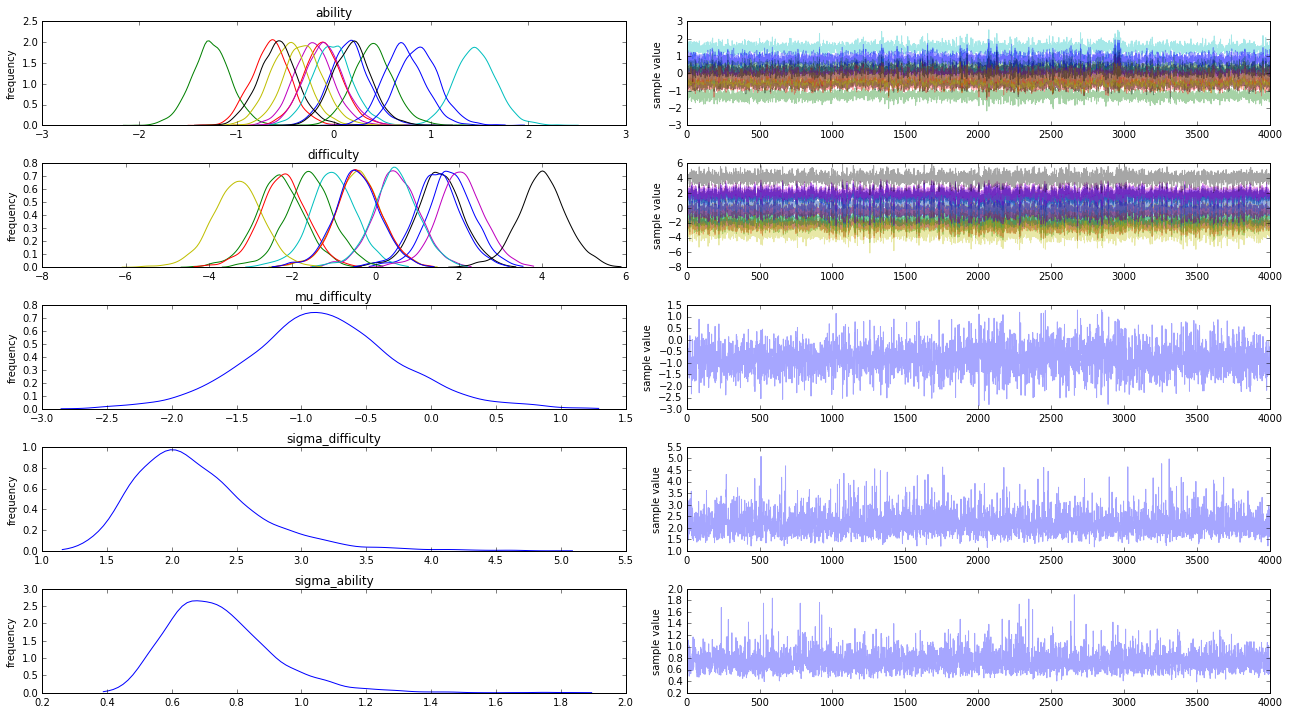

In [5]:
# fit model
binary_fit = binary_irt_model.sampling(data=binary_sim_data, iter=2000, chains=4)
# extract parameters
binary_params = binary_fit.extract()
# print fit summary
print(binary_fit)
# draw summary plot
f = binary_fit.plot()
f.set_size_inches(18, 10)
plt.tight_layout()

From the fit summary we can see that the model converged acceptably and that the parameters are roughly in the right ballpark. 

To get a more detailed idea about how well the parameters were recovered, we can draw some more graphs:

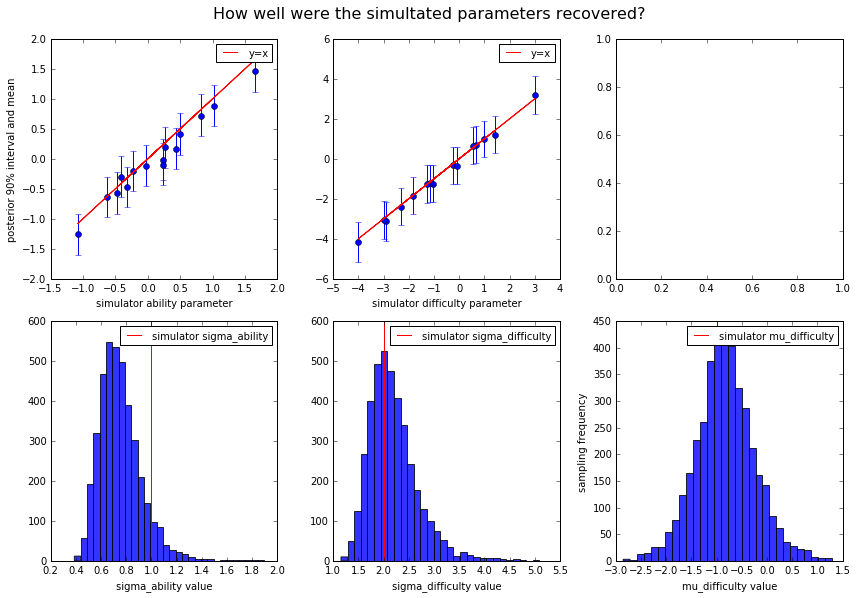

In [6]:
# define some names for convenience
binary_sim_ability = binary_sim_recoverables['ability']
binary_sim_difficulty = binary_sim_recoverables['difficulty']
# Work out upper and lower quantiles
binary_ability_quantiles = percentile(binary_params['ability'], [5, 95], axis=0)
binary_difficulty_quantiles = percentile(binary_params['difficulty'], [5, 95], axis=0)
# draw Graphs
f, ax = plt.subplots(2, 3, figsize=[12, 8])
ax = ax.ravel()
f.suptitle('How well were the simultated parameters recovered?', y=1.03, fontsize=16)
# ability
ax[0].set_xlabel('simulator ability parameter')
ax[0].set_ylabel('posterior 90% interval and mean')
ax[0].errorbar(binary_sim_ability, 
               binary_params['ability'].mean(axis=0),
               yerr=abs(binary_params['ability'].mean(axis=0) - binary_ability_quantiles),
               fmt='o')
ax[0].plot(binary_sim_ability, binary_sim_ability, color='r')
ax[0].legend(['y=x'], prop={'size': 10})
# difficulty
ax[1].set_xlabel('simulator difficulty parameter')
ax[1].errorbar(binary_sim_difficulty,
               binary_params['difficulty'].mean(axis=0) + binary_params['mu_difficulty'].mean(),
               yerr=abs(binary_params['difficulty'].mean(axis=0) - binary_difficulty_quantiles),
               fmt='o')
ax[1].plot(binary_sim_difficulty, binary_sim_difficulty, color='r')
ax[1].legend(['y=x'], prop={'size': 10})
# mu_difficulty
ax[5].hist(binary_params['mu_difficulty'], alpha=0.8, bins=30)
ax[5].axvline(binary_sim_recoverables['mu_difficulty'], color='r')
ax[5].legend(['simulator mu_difficulty'], prop={'size': 10})
ax[5].set_xlabel('mu_difficulty value')
ax[5].set_ylabel('sampling frequency')
# sigma_difficulty
ax[4].hist(binary_params['sigma_difficulty'], alpha=0.8, bins=30)
ax[4].axvline(binary_sim_recoverables['sigma_difficulty'], color='r')
ax[4].legend(['simulator sigma_difficulty'], prop={'size': 10})
ax[4].set_xlabel('sigma_difficulty value')
# sigma_ability
ax[3].hist(binary_params['sigma_ability'], alpha=0.8, bins=30)
ax[3].axvline(binary_sim_recoverables['sigma_ability'], color='r')
ax[3].legend(['simulator sigma_ability'], prop={'size': 10})
ax[3].set_xlabel('sigma_ability value')

plt.tight_layout()

The parameters that we put into the simulator were recovered fairly well: it looks like our binary IRT model works.

This kind of plot is useful for checking whether our soft centering strategy has worked. If, not, then we may see the ability and difficulty parameters all missing the mark by about the same amount in the same direction - in this case it might be time to try hard centering.

## Graded IRT model
As well as classifying actions as either successful or unsucessful, our data might assign numerical grades. In this case we have the option of using a _graded_, as opposed to binary, IRT model. The main difference from the binary model is that instead of one difficulty parameter per item we now have multiple difficulty parameters for each item, and the distribution of grades is now characterised by the following equation:

$$pr(grade_{ij} > k) = logistic(ability_{j} - difficulty_{ik})$$

Now let's try coding a graded model and using it to recover some more simulated parameters.
### Model
We will restrict our attention to cases where the number of possible grades is the same for each item. See Daniel Furr's model [here](https://groups.google.com/forum/#!searchin/stan-users/daniel$20grm/stan-users/viQXrMU7vU0/2miXQOqpBgAJ) for a more general graded IRT model.

Here is the Stan code for this model:

```
data {
  // numbers of things
  int<lower=1> I;  // items
  int<lower=1> S;  // subjects
  int<lower=1> R;  // responses
  int<lower=1> G;  // grades

  // training data
  int<lower=1,upper=I> item[R];
  int<lower=1,upper=S> subject[R];
  int<lower=1,upper=G> grade[R];
}
parameters {
  // parameters
  ordered[G-1] difficulty[I];
  vector[S] ability;

  // hyperparameters
  real mu_first_difficulty;
  real<lower=0> sigma_ability;
  real<lower=0> sigma_first_difficulty;
  real<lower=0> sigma_step;
}
model {
  // priors
  ability ~ normal(0, sigma_ability);
  difficulty[1:I, 1] ~ normal(mu_first_difficulty,
                              sigma_first_difficulty); // prior for easiest grades
  for (i in 1:I){
    difficulty[i, 2:G-1]
    - difficulty[i, 1:G-2] ~ normal(0, sigma_step);  // priors for steps between grades
  }

  // data model
  for (response in 1:R){
    grade[response] ~ ordered_logistic(ability[subject[response]],
                                       difficulty[item[response]]);}
}

```


This model doesn't explicitly set priors for all its parameters. Rather, it sets priors for ability and the difficulties of the first grade for each item as before, then puts a hierarchical prior on the difficulty steps. This represents the plausible view that the steps in difficulty from one grade to the next tend to be about the same from grade to grade and from item to item. Depending on the application, it might be more appropriate to estimate a separate step parameter for each item - this could be achieved by making `sigma_step` a vector and indexing it where it appears in the model.

In [7]:
# compile the model
graded_irt_model = pystan.StanModel(file="graded_irt.stan")

### Simulated data
Generating simulated data is a bit trickier in this case, but can still be done using roughly the same approach.

In [8]:
# pmf for the ordered logistic distribution
def get_ordered_logistic_probs(ability, item_difficulties):
    # NB the '+' operators here represent list concatenation not addition
    return array([1 - expit(ability - item_difficulties[0])] +
                  [expit(ability - item_difficulties[grade - 1]) - 
                   expit(ability - item_difficulties[grade])
                   for grade in range(1, len(item_difficulties))] +
                  [expit(ability - item_difficulties[len(item_difficulties) - 1])])

# function for generating graded irt data
def generate_graded_irt_data(sim_input):
    # abilities
    sim_ability = normal(loc=0,
                         scale=1,
                         size=sim_input['S'])
    # difficulty of the easiest grade for each item
    sim_first_difficulty = normal(loc=sim_input['mu_first_difficulty'],
                                  scale=sim_input['sigma_first_difficulty'],
                                  size=(sim_input['I'], 1))
    # size of steps from one grade to the next for each item
    sim_difficulty_steps = abs(normal(loc=0,
                                      scale=sim_input['sigma_step'],
                                      size=(sim_input['I'], sim_input['G']-2)))
    # cumulatively add first difficulties to steps to get overall difficulties
    sim_difficulty = append(sim_first_difficulty,
                            sim_difficulty_steps, 
                            axis=1).cumsum(axis=1)
    # assign subjects and items
    sim_subject = randint(low=0,
                          high=sim_input['S'],
                          size=sim_input['R'])
    sim_item = randint(low=0,
                       high=sim_input['I'],
                       size=sim_input['R'])
    # calculate outcome probabilities for each response
    sim_probs = [get_ordered_logistic_probs(*i) 
                 for i in zip(sim_ability[sim_subject], sim_difficulty[sim_item])]
    # generate random grades
    sim_grade = concatenate([choice(a=range(1, sim_input['G'] + 1),
                                    size=1,
                                    p=sim_probs[i]) 
                             for i in range(sim_input['R'])])
    # dictionary of data that we will give to Stan
    sim_data = {
        'subject': sim_subject + 1,
        'item': sim_item + 1,
        'grade': sim_grade
    }
    sim_data.update({i: sim_input[i] for i in ['R', 'I', 'S', 'G']})
    # dictionary of numbers we want to recover
    recoverables = {
        'ability': sim_ability,
        'difficulty': sim_difficulty,
    }
    recoverables.update({i: sim_input[i] for i in ['sigma_ability',
                                                   'sigma_first_difficulty',
                                                   'sigma_step',
                                                   'mu_first_difficulty']})
    return sim_data, recoverables

# Some input data
graded_sim_input = {'R': 10000,
                    'I': 5,
                    'S': 15,
                    'G': 4,
                    'sigma_ability': 1,
                    'sigma_first_difficulty': 2,
                    'sigma_step': 1.5,
                    'mu_first_difficulty': -1}
graded_sim_data, graded_sim_recoverables = generate_graded_irt_data(graded_sim_input)

The model can be fit just as before, but we can't draw traceplots because the `difficulty` parameter has too many dimensions

In [9]:
# fit model
graded_fit = graded_irt_model.sampling(data=graded_sim_data, iter=3000, chains=4)
# extract parameters
graded_params = graded_fit.extract()
# print fit summary
print(graded_fit)

Inference for Stan model: anon_model_05bd49fa7ce0be3a98d51da1cd1875ce.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
difficulty[0,0]           1.4    0.01   0.32   0.75    1.2   1.41   1.61   2.04    517    1.0
difficulty[1,0]         -2.19    0.01   0.32  -2.85   -2.4  -2.19  -1.98  -1.56    532    1.0
difficulty[2,0]          1.03    0.01   0.32   0.38   0.84   1.04   1.24   1.66    520    1.0
difficulty[3,0]         -1.29    0.01   0.32  -1.93  -1.49  -1.28  -1.08  -0.67    524    1.0
difficulty[4,0]         -2.15    0.01   0.32  -2.81  -2.35  -2.14  -1.94  -1.52    527    1.0
difficulty[0,1]          2.01    0.01   0.32   1.36   1.81   2.02   2.23   2.65    524    1.0
difficulty[1,1]         -0.99    0.01   0.32  -1.64   -1.2  -0.99  -0.78  -0.37    521    1.0
difficulty[2,1]          1.13    0.01   0.32   0.47   0.93 

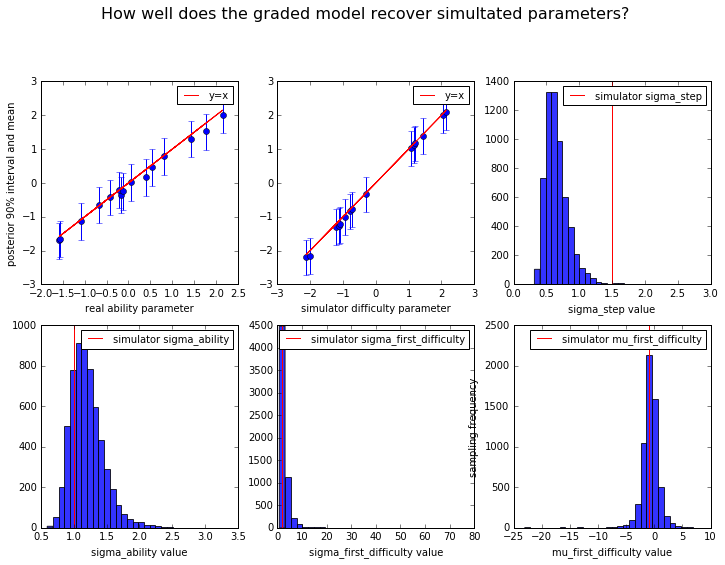

In [15]:
# work out quantiles
graded_ability_quantiles = percentile(graded_params['ability'], [5, 95], axis=0)
graded_difficulty_quantiles = [
    concatenate(i) for i in percentile(graded_params['difficulty'], [5, 95], axis=0)
]
# some convenience names
graded_ability_means = graded_params['ability'].mean(axis=0)
graded_difficulty_means = concatenate(graded_params['difficulty'].mean(axis=0))
graded_sim_ability = graded_sim_recoverables['ability']
graded_sim_difficulty = concatenate(graded_sim_recoverables['difficulty'])
# start drawing graphs                 
f, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.ravel()
f.suptitle('How well does the graded model recover simultated parameters?', y=1.03, fontsize=16)
# ability
ax[0].set_xlabel('real ability parameter')
ax[0].set_ylabel('posterior 90% interval and mean')
ax[0].errorbar(graded_sim_ability,
               graded_ability_means,
               yerr=abs(graded_ability_means - graded_ability_quantiles),
               fmt='o')
ax[0].plot(graded_sim_ability, graded_sim_ability, color='r')
ax[0].legend(['y=x'], prop={'size': 10})
# difficulty
ax[1].set_xlabel('simulator difficulty parameter')
ax[1].errorbar(graded_sim_difficulty, 
               graded_difficulty_means,
               yerr=abs(graded_difficulty_means - graded_difficulty_quantiles), 
               fmt='o')
ax[1].plot(graded_sim_difficulty, graded_sim_difficulty, color='r')
ax[1].legend(['y=x'], prop={'size': 10})
# sigma_step
ax[2].hist(graded_params['sigma_step'], alpha=0.8, bins=30)
ax[2].axvline(graded_sim_recoverables['sigma_step'], color='r')
ax[2].legend(['simulator sigma_step'], prop={'size': 10})
ax[2].set_xlabel('sigma_step value')
# sigma_ability
ax[3].hist(graded_params['sigma_ability'], alpha=0.8, bins=30)
ax[3].axvline(graded_sim_recoverables['sigma_ability'], color='r')
ax[3].legend(['simulator sigma_ability'], prop={'size': 10})
ax[3].set_xlabel('sigma_ability value')
# sigma_first_difficulty
ax[4].hist(graded_params['sigma_first_difficulty'], alpha=0.8, bins=30)
ax[4].axvline(graded_sim_recoverables['sigma_first_difficulty'], color='r')
ax[4].legend(['simulator sigma_first_difficulty'], prop={'size': 10})
ax[4].set_xlabel('sigma_first_difficulty value')
# mu_first_difficulty
ax[5].hist(graded_params['mu_first_difficulty'], alpha=0.8, bins=30)
ax[5].axvline(graded_sim_recoverables['mu_first_difficulty'], color='r')
ax[5].legend(['simulator mu_first_difficulty'], prop={'size': 10})
ax[5].set_xlabel('mu_first_difficulty value')
ax[5].set_ylabel('sampling frequency')

The real parameters were recovered fairly well!

## Cross-validation
Following the approach outlined in Vehtari, Gelman and Gabry (2016), we can use Stan to do a lot of the work of cross-validating our models. This can be very useful for testing our modelling assumptions - for example, was it right to treat separate responses as independent, and should we really have used the same step-deviation parameter for all the items? More broadly, this kind of test is useful for deciding whether it is worth collecting the data that the model was based on.

In order to cross-validate our graded model, we need to add some extra code to allow the model to distinguish training data from test ('holdout') data, and use the `generated quantities` block to tell the model to generate some predictions about any 'holdout' data it is given.

Here is the extra code we need to add:
```
data {
  ... 
  int<lower=1> R_holdout;
  int<lower=1,upper=I> item_holdout[R_holdout];
  int<lower=1,upper=S> subject_holdout[R_holdout];
}
...
generated quantities {
  int<lower=0,upper=G> predicted_grade[R_holdout];
  for (response in 1:R_holdout) {
    predicted_grade[response] = ordered_logistic_rng(
      ability[subject_holdout[response]], difficulty[item_holdout[response]]
    );                                          
  }
}
```

After creating a new `graded_irt_x_val.stan` file added we can now do n-fold cross-validation, fitting our graded model on a subset of our data and using the resulting parameters to make predictions about the remaining data.

In [11]:
# Compile the cross-validation model
graded_irt_model_xval = pystan.StanModel(file="graded_irt_xval.stan")
# Number of chunks to partition the data into:
n_folds = 5
whole_dataset = pd.DataFrame({i: graded_sim_data[i] 
                              for i in ['item', 'subject', 'grade']})
test_dataset = whole_dataset.copy()
predictions = pd.DataFrame([])
for fold in range(n_folds):
    test_data = test_dataset.sample(n=int(len(whole_dataset) / n_folds))
    training_data = whole_dataset.drop(test_data.index)
    this_fold_data = {'I': len(whole_dataset['item'].unique()),
                      'S': len(whole_dataset['subject'].unique()),
                      'G': len(whole_dataset['grade'].unique()),
                      'R': len(training_data),
                      'item': training_data['item'],
                      'subject': training_data['subject'],
                      'grade': training_data['grade'],
                      'R_holdout': len(test_data),
                      'item_holdout': test_data['item'],
                      'subject_holdout': test_data['subject']}
    this_fold_fit = graded_irt_model_xval.sampling(data=this_fold_data, iter=200, chains=4)
    this_fold_params = this_fold_fit.extract()
    this_fold_predictions = pd.DataFrame(this_fold_params['predicted_grade'].T,
                                         index=test_data.index)
    predictions = pd.concat([predictions, this_fold_predictions])
    test_dataset = test_dataset.drop(test_data.index)
predictions.sort_index(inplace=True)
predictions.columns = ['prediction_' + str(i) for i in predictions.columns]
output = whole_dataset.join(predictions)
output.head()

,grade,item,subject,prediction_0,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,...,prediction_390,prediction_391,prediction_392,prediction_393,prediction_394,prediction_395,prediction_396,prediction_397,prediction_398,prediction_399
0,4,4,15,4.0,1.0,4.0,4.0,4.0,1.0,4.0,...,4.0,4.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,1.0
1,4,2,8,4.0,3.0,4.0,4.0,4.0,3.0,4.0,...,4.0,1.0,2.0,4.0,4.0,4.0,3.0,3.0,2.0,2.0
2,2,5,10,4.0,1.0,4.0,1.0,2.0,1.0,4.0,...,4.0,3.0,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0
3,1,3,14,4.0,4.0,1.0,1.0,1.0,1.0,1.0,...,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0
4,4,1,5,4.0,1.0,1.0,1.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [12]:
mae = (pd.DataFrame([abs(output[i] - output['grade']) 
                     for i in output[predictions.columns]])
       .mean(axis=1)
       .mean())
mse = (pd.DataFrame([(output[i] - output['grade']) ** 2
                     for i in output[predictions.columns]])
       .mean(axis=1)
       .mean())
print('Mean absolute error: ' + str(mae) + '\nMean square error: ' + str(mse))

Mean absolute error: 0.9330315
Mean square error: 2.3869025


These error numbers can now be used to compare this IRT model with alternative specifications, or to inform a decision about how worthwhile it is to collect this kind of data.

## References
Vehtari, A., Gelman, A. and Gabry, J (2016).
[Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC](http://www.stat.columbia.edu/~gelman/research/unpublished/loo_stan.pdf), arXiv:1507.04544

Gelman, A., and Hill, J. (2006). [_Data Analysis Using Regression and Multilevel/Hierarchical Models_](http://www.stat.columbia.edu/~gelman/arm/) Cambridge University Press.
